# Recognizing Human Activities using Smartphones
## Classification on Smartphone-Based Recognition of Human Activities and Postural Transitions Dataset

### Preliminary Exploratory Data Analysis & Methods

In [1]:
# First, we will load required packages
library(repr)
library(knitr)
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
library(GGally)

# Then, set the seed
set.seed(1)

Warning message:
“package ‘knitr’ was built under R version 4.0.1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1

### I. Demonstrate that the dataset can be read from the web into R

In [2]:
# Data source: http://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions#
url <- "http://archive.ics.uci.edu/ml/machine-learning-databases/00341/HAPT%20Data%20Set.zip"

# Specifying destination where file should be saved
destfile <- "data/localfile.zip"

# Apply download.file function 
download.file(url, destfile)

unzip ("data/localfile.zip", exdir = "data/")

### II. Clean and wrangle data into a tidy format

In [3]:
# create a vector of features to use for col names of training data
#X1 represents the row number
#X2 is the features 
features_table <- read_delim("data/UCI HAR Dataset/features.txt", delim = " ", col_names = FALSE)
glimpse(features_table)
features_vector <- dplyr::pull(features_table, 'X2')
features_vector_sub <- gsub("-", "_", features_vector)

features_vector_sub <- gsub("[()]", "", features_vector_sub)
glimpse(features_vector_sub)

Parsed with column specification:
cols(
  X1 = col_double(),
  X2 = col_character()
)



Rows: 561
Columns: 2
$ X1 <dbl> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,…
$ X2 <chr> "tBodyAcc-mean()-X", "tBodyAcc-mean()-Y", "tBodyAcc-mean()-Z", "tB…
 chr [1:561] "tBodyAcc_mean_X" "tBodyAcc_mean_Y" "tBodyAcc_mean_Z" ...


In [4]:
# create a table of activity labels to add such a variable as a column into the training set data frame.
label_col_name_vec <- c('activity_label')
y_training_label <- read_delim("data/UCI HAR Dataset/train/y_train.txt", delim = " ", col_names = label_col_name_vec) 

y_testing_label <- read_delim("data/UCI HAR Dataset/test/y_test.txt", delim = " ", col_names = label_col_name_vec)

Parsed with column specification:
cols(
  activity_label = col_double()
)

Parsed with column specification:
cols(
  activity_label = col_double()
)



In [5]:
# read feature values 
x_training_data <- read_delim("data/UCI HAR Dataset/train/X_train.txt", delim = " ", col_names = features_vector_sub)

x_testing_data <- read_delim("data/UCI HAR Dataset/test/X_test.txt", delim = " ", col_names = features_vector_sub)

Warning message:
“Duplicated column names deduplicated: 'fBodyAcc_bandsEnergy_1,8' => 'fBodyAcc_bandsEnergy_1,8_1' [317], 'fBodyAcc_bandsEnergy_9,16' => 'fBodyAcc_bandsEnergy_9,16_1' [318], 'fBodyAcc_bandsEnergy_17,24' => 'fBodyAcc_bandsEnergy_17,24_1' [319], 'fBodyAcc_bandsEnergy_25,32' => 'fBodyAcc_bandsEnergy_25,32_1' [320], 'fBodyAcc_bandsEnergy_33,40' => 'fBodyAcc_bandsEnergy_33,40_1' [321], 'fBodyAcc_bandsEnergy_41,48' => 'fBodyAcc_bandsEnergy_41,48_1' [322], 'fBodyAcc_bandsEnergy_49,56' => 'fBodyAcc_bandsEnergy_49,56_1' [323], 'fBodyAcc_bandsEnergy_57,64' => 'fBodyAcc_bandsEnergy_57,64_1' [324], 'fBodyAcc_bandsEnergy_1,16' => 'fBodyAcc_bandsEnergy_1,16_1' [325], 'fBodyAcc_bandsEnergy_17,32' => 'fBodyAcc_bandsEnergy_17,32_1' [326], 'fBodyAcc_bandsEnergy_33,48' => 'fBodyAcc_bandsEnergy_33,48_1' [327], 'fBodyAcc_bandsEnergy_49,64' => 'fBodyAcc_bandsEnergy_49,64_1' [328], 'fBodyAcc_bandsEnergy_1,24' => 'fBodyAcc_bandsEnergy_1,24_1' [329], 'fBodyAcc_bandsEnergy_25,48' => 'fBodyAcc_ba

In [6]:
# add activity label column to data
training_set_all <- bind_cols(x_training_data, y_training_label)
tail(training_set_all)

testing_set_all <- bind_cols(x_testing_data, y_testing_label)
tail(testing_set_all)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
2.3796648e-001,-1.0878070e-003,-1.4832590e-001,-2.1894876e-001,-1.2926748e-002,1.7001874e-001,-3.0959929e-001,-4.1392263e-002,2.0745436e-001,2.1079544e-001,⋯,-5.9248831e-001,-8.6723607e-001,3.5277575e-001,-6.0481685e-001,-7.7478312e-001,7.3014246e-001,-7.9727183e-001,2.3499575e-001,4.8907023e-002,2
2.9966534e-001,-5.7193414e-002,-1.8123302e-001,-1.9538652e-001,3.9904850e-002,7.7078081e-002,-2.8230064e-001,4.3615631e-002,6.0410083e-002,2.1079544e-001,⋯,-5.8843274e-001,-8.8032443e-001,-1.9043686e-001,8.2971842e-001,2.0697215e-001,-4.2561858e-001,-7.9188305e-001,2.3860439e-001,4.9819139e-002,2
2.7385271e-001,-7.7493259e-003,-1.4746837e-001,-2.3530853e-001,4.8162805e-003,5.9279994e-002,-3.2255234e-001,-2.9456250e-002,8.0585116e-002,1.1744028e-001,⋯,-3.9073832e-001,-6.8074445e-001,6.4906712e-002,8.7567905e-001,-8.7903279e-001,4.0021936e-001,-7.7183960e-001,2.5267595e-001,5.0052558e-002,2
2.7338737e-001,-1.7010616e-002,-4.5021828e-002,-2.1821818e-001,-1.0382198e-001,2.7453270e-001,-3.0451515e-001,-9.8913034e-002,3.3258449e-001,4.3998772e-002,⋯,2.5145333e-002,-3.0402936e-001,5.2805928e-002,-2.6672437e-001,8.6440401e-001,7.0116882e-001,-7.7913261e-001,2.4914484e-001,4.0811188e-002,2
2.8965416e-001,-1.8843044e-002,-1.5828059e-001,-2.1913944e-001,-1.1141169e-001,2.6889320e-001,-3.1048749e-001,-6.8200325e-002,3.1947326e-001,1.0170184e-001,⋯,6.3906883e-002,-3.4431361e-001,-1.0136012e-001,7.0073969e-001,9.3667394e-001,-5.8947895e-001,-7.8518142e-001,2.4643223e-001,2.5339478e-002,2
3.5150347e-001,-1.2423118e-002,-2.0386717e-001,-2.6927044e-001,-8.7211541e-002,1.7740393e-001,-3.7740405e-001,-3.8678063e-002,2.2942952e-001,2.6901269e-001,⋯,-3.8705200e-001,-7.4073820e-001,-2.8008805e-001,-7.7392783e-003,-5.6087594e-002,-6.1695645e-001,-7.8326693e-001,2.4680852e-001,3.6694843e-002,2


tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,⋯,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1.9227459e-001,-3.3642566e-002,-1.0594911e-001,-3.5484079e-001,-9.2504346e-002,-3.1290968e-001,-4.3357927e-001,-8.8741465e-002,-3.3605968e-001,-4.1623509e-002,⋯,-6.2965677e-001,-9.1649344e-001,5.3598268e-001,6.8930613e-001,-9.3660649e-001,5.6237487e-001,-6.4675433e-001,2.8215019e-001,1.8115158e-001,2
3.1015462e-001,-5.3391250e-002,-9.9108716e-002,-2.8786635e-001,-1.4058918e-001,-2.1508773e-001,-3.5608315e-001,-1.4877483e-001,-2.3205733e-001,1.8536146e-001,⋯,-3.7627777e-001,-7.5080906e-001,-3.3742157e-001,3.4629489e-001,8.8490383e-001,-6.9888508e-001,-6.5173235e-001,2.7462678e-001,1.8478430e-001,2
3.6338465e-001,-3.9214016e-002,-1.0591509e-001,-3.0538795e-001,2.8147742e-002,-1.9637291e-001,-3.7353982e-001,-3.0036042e-002,-2.7023668e-001,1.8536146e-001,⋯,-3.2041786e-001,-7.0027424e-001,-7.3670095e-001,-3.7288894e-001,-6.5742051e-001,3.2254850e-001,-6.5518092e-001,2.7357825e-001,1.8241215e-001,2
3.4996609e-001,3.0077442e-002,-1.1578796e-001,-3.2963808e-001,-4.2142894e-002,-2.5018068e-001,-3.8801695e-001,-1.3325698e-001,-3.4702897e-001,7.4714557e-003,⋯,-1.1885353e-001,-4.6717918e-001,-1.8156041e-001,8.8574068e-002,6.9666350e-001,3.6313871e-001,-6.5535684e-001,2.7447878e-001,1.8118355e-001,2
2.3759383e-001,1.8466870e-002,-9.6498932e-002,-3.2311431e-001,-2.2977539e-001,-2.0757363e-001,-3.9238016e-001,-2.7961019e-001,-2.8947740e-001,7.4714557e-003,⋯,-2.0544513e-001,-6.1773651e-001,4.4455767e-001,-8.1918771e-001,9.2929414e-001,-8.3982494e-003,-6.5971859e-001,2.6478161e-001,1.8756291e-001,2
1.5362719e-001,-1.8436506e-002,-1.3701846e-001,-3.3004597e-001,-1.9525335e-001,-1.6433879e-001,-4.3097381e-001,-2.1829465e-001,-2.2993287e-001,-1.1152697e-001,⋯,-7.2237101e-002,-4.3694001e-001,5.9880823e-001,-2.8795067e-001,8.7602991e-001,-2.4965139e-002,-6.6008023e-001,2.6393619e-001,1.8810340e-001,2


In [43]:
# combine all the data into one
bothdfs <- rbind(training_set_all, testing_set_all) %>%
      mutate(activity_label = as_factor(activity_label), 
            across(tBodyAcc_mean_X:fBodyBodyGyroJerkMag_skewness, as.numeric)) %>% 
      na.omit()
tail(bothdfs)

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,"tBodyAcc_arCoeff_X,1","tBodyAcc_arCoeff_X,2","tBodyAcc_arCoeff_X,3","tBodyAcc_arCoeff_X,4","tBodyAcc_arCoeff_Y,1","tBodyAcc_arCoeff_Y,2","tBodyAcc_arCoeff_Y,3","tBodyAcc_arCoeff_Y,4","tBodyAcc_arCoeff_Z,1","tBodyAcc_arCoeff_Z,2","tBodyAcc_arCoeff_Z,3","tBodyAcc_arCoeff_Z,4","tBodyAcc_correlation_X,Y","tBodyAcc_correlation_X,Z","tBodyAcc_correlation_Y,Z",tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,"tGravityAcc_arCoeff_X,1","tGravityAcc_arCoeff_X,2","tGravityAcc_arCoeff_X,3","tGravityAcc_arCoeff_X,4","tGravityAcc_arCoeff_Y,1","tGravityAcc_arCoeff_Y,2","tGravityAcc_arCoeff_Y,3","tGravityAcc_arCoeff_Y,4","tGravityAcc_arCoeff_Z,1","tGravityAcc_arCoeff_Z,2",⋯,"fBodyGyro_bandsEnergy_25,48_1","fBodyGyro_bandsEnergy_1,8_2","fBodyGyro_bandsEnergy_9,16_2","fBodyGyro_bandsEnergy_17,24_2","fBodyGyro_bandsEnergy_25,32_2","fBodyGyro_bandsEnergy_33,40_2","fBodyGyro_bandsEnergy_41,48_2","fBodyGyro_bandsEnergy_49,56_2","fBodyGyro_bandsEnergy_57,64_2","fBodyGyro_bandsEnergy_1,16_2","fBodyGyro_bandsEnergy_17,32_2","fBodyGyro_bandsEnergy_33,48_2","fBodyGyro_bandsEnergy_49,64_2","fBodyGyro_bandsEnergy_1,24_2","fBodyGyro_bandsEnergy_25,48_2",fBodyAccMag_mean,fBodyAccMag_std,fBodyAccMag_mad,fBodyAccMag_max,fBodyAccMag_min,fBodyAccMag_sma,fBodyAccMag_energy,fBodyAccMag_iqr,fBodyAccMag_entropy,fBodyAccMag_maxInds,fBodyAccMag_meanFreq,fBodyAccMag_skewness,fBodyAccMag_kurtosis,fBodyBodyAccJerkMag_mean,fBodyBodyAccJerkMag_std,fBodyBodyAccJerkMag_mad,fBodyBodyAccJerkMag_max,fBodyBodyAccJerkMag_min,fBodyBodyAccJerkMag_sma,fBodyBodyAccJerkMag_energy,fBodyBodyAccJerkMag_iqr,fBodyBodyAccJerkMag_entropy,fBodyBodyAccJerkMag_maxInds,fBodyBodyAccJerkMag_meanFreq,fBodyBodyAccJerkMag_skewness,fBodyBodyAccJerkMag_kurtosis,fBodyBodyGyroMag_mean,fBodyBodyGyroMag_std,fBodyBodyGyroMag_mad,fBodyBodyGyroMag_max,fBodyBodyGyroMag_min,fBodyBodyGyroMag_sma,fBodyBodyGyroMag_energy,fBodyBodyGyroMag_iqr,fBodyBodyGyroMag_entropy,fBodyBodyGyroMag_maxInds,fBodyBodyGyroMag_meanFreq,fBodyBodyGyroMag_skewness,fBodyBodyGyroMag_kurtosis,fBodyBodyGyroJerkMag_mean,fBodyBodyGyroJerkMag_std,fBodyBodyGyroJerkMag_mad,fBodyBodyGyroJerkMag_max,fBodyBodyGyroJerkMag_min,fBodyBodyGyroJerkMag_sma,fBodyBodyGyroJerkMag_energy,fBodyBodyGyroJerkMag_iqr,fBodyBodyGyroJerkMag_entropy,fBodyBodyGyroJerkMag_maxInds,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<db

Our dataset is tidy because each row is a single observation, each column is a single variable, and each value is a single cell.

In [44]:
# random spliting of the combined entire dataset into train (75%) and test (25%)
bothdfs_split <- initial_split(bothdfs, prop = 0.75, strata = activity_label)
activity_train <- training(bothdfs_split) 
activity_test <- testing(bothdfs_split) 

In [45]:
#view column/feature names
names(bothdfs)

[1] "tBodyAcc_mean_X"                    "tBodyAcc_mean_Y"                   
  [3] "tBodyAcc_mean_Z"                    "tBodyAcc_std_X"                    
  [5] "tBodyAcc_std_Y"                     "tBodyAcc_std_Z"                    
  [7] "tBodyAcc_mad_X"                     "tBodyAcc_mad_Y"                    
  [9] "tBodyAcc_mad_Z"                     "tBodyAcc_max_X"                    
 [11] "tBodyAcc_max_Y"                     "tBodyAcc_max_Z"                    
 [13] "tBodyAcc_min_X"                     "tBodyAcc_min_Y"                    
 [15] "tBodyAcc_min_Z"                     "tBodyAcc_sma"                      
 [17] "tBodyAcc_energy_X"                  "tBodyAcc_energy_Y"                 
 [19] "tBodyAcc_energy_Z"                  "tBodyAcc_iqr_X"                    
 [21] "tBodyAcc_iqr_Y"                     "tBodyAcc_iqr_Z"                    
 [23] "tBodyAcc_entropy_X"                 "tBodyAcc_entropy_Y"                
 [25] "tBodyAcc_entropy_Z"                 "tBodyAcc_arCoeff_X,1"              
 [27] "tBodyAcc_arCoeff_X,2"               "tBodyAcc_arCoeff_X,3"              
 [29] "tBodyAcc_arCoeff_X,4"               "tBodyAcc_arCoeff_Y,1"              
 [31] "tBodyAcc_arCoeff_Y,2"               "tBodyAcc_arCoeff_Y,3"              
 [33] "tBodyAcc_arCoeff_Y,4"               "tBodyAcc_arCoeff_Z,1"              
 [35] "tBodyAcc_arCoeff_Z,2"               "tBodyAcc_arCoeff_Z,3"              
 [37] "tBodyAcc_arCoeff_Z,4"               "tBodyAcc_correlation_X,Y"          
 [39] "tBodyAcc_correlation_X,Z"           "tBodyAcc_correlation_Y,Z"          
 [41] "tGravityAcc_mean_X"                 "tGravityAcc_mean_Y"                
 [43] "tGravityAcc_mean_Z"                 "tGravityAcc_std_X"                 
 [45] "tGravityAcc_std_Y"                  "tGravityAcc_std_Z"                 
 [47] "tGravityAcc_mad_X"                  "tGravityAcc_mad_Y"                 
 [49] "tGravityAcc_mad_Z"                  "tGravityAcc_max_X"                 
 [51] "tGravityAcc_max_Y"                  "tGravityAcc_max_Z"                 
 [53] "tGravityAcc_min_X"                  "tGravityAcc_min_Y"                 
 [55] "tGravityAcc_min_Z"                  "tGravityAcc_sma"                   
 [57] "tGravityAcc_energy_X"               "tGravityAcc_energy_Y"              
 [59] "tGravityAcc_energy_Z"               "tGravityAcc_iqr_X"                 
 [61] "tGravityAcc_iqr_Y"                  "tGravityAcc_iqr_Z"                 
 [63] "tGravityAcc_entropy_X"              "tGravityAcc_entropy_Y"             
 [65] "tGravityAcc_entropy_Z"              "tGravityAcc_arCoeff_X,1"           
 [67] "tGravityAcc_arCoeff_X,2"            "tGravityAcc_arCoeff_X,3"           
 [69] "tGravityAcc_arCoeff_X,4"            "tGravityAcc_arCoeff_Y,1"           
 [71] "tGravityAcc_arCoeff_Y,2"            "tGravityAcc_arCoeff_Y,3"           
 [73] "tGravityAcc_arCoeff_Y,4"            "tGravityAcc_arCoeff_Z,1"           
 [75] "tGravityAcc_arCoeff_Z,2"            "tGravityAcc_arCoeff_Z,3"           
 [77] "tGravityAcc_arCoeff_Z,4"            "tGravityAcc_correlation_X,Y"       
 [79] "tGravityAcc_correlation_X,Z"        "tGravityAcc_correlation_Y,Z"       
 [81] "tBodyAccJerk_mean_X"                "tBodyAccJerk_mean_Y"               
 [83] "tBodyAccJerk_mean_Z"                "tBodyAccJerk_std_X"                
 [85] "tBodyAccJerk_std_Y"                 "tBodyAccJerk_std_Z"                
 [87] "tBodyAccJerk_mad_X"                 "tBodyAccJerk_mad_Y"                
 [89] "tBodyAccJerk_mad_Z"                 "tBodyAccJerk_max_X"                
 [91] "tBodyAccJerk_max_Y"                 "tBodyAccJerk_max_Z"                
 [93] "tBodyAccJerk_min_X"                 "tBodyAccJerk_min_Y"                
 [95] "tBodyAccJerk_min_Z"                 "tBodyAccJerk_sma"                  
 [97] "tBodyAccJerk_energy_X"              "tBodyAccJerk_energy_Y"             
 [99] "tBodyAccJerk_energy_Z"              "tBodyAccJerk_iqr_X"                
[1

In [46]:
#Determining correlation of variables to choose relevant predictors 
options(repr.matrix.max.cols=150, repr.matrix.max.rows=6)

#features related to acceleration 
#tBodyAcc_mean_X:tBodyAcc_energy_Z
relevant_acc_columns <- bothdfs %>% 
    select(tBodyAcc_mean_X:tBodyAcc_std_Z, activity_label)  
relevant_acc_columns 

#features related to angular velocity 
#tBodyGyro_mean_X:tBodyGyro_energy_Z
relevant_ang_columns <- bothdfs %>% 
    select(tBodyGyro_mean_X:tBodyGyro_std_Z, activity_label)  
relevant_ang_columns 

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.2885845,-0.02029417,-0.1329051,-0.9952786,-0.9831106,-0.9135264,5
0.2784188,-0.01641057,-0.1235202,-0.9982453,-0.9753002,-0.9603220,5
0.2796531,-0.01946716,-0.1134617,-0.9953796,-0.9671870,-0.9789440,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
0.3499661,0.03007744,-0.11578796,-0.3296381,-0.04214289,-0.2501807,2
0.2375938,0.01846687,-0.09649893,-0.3231143,-0.22977539,-0.2075736,2
0.1536272,-0.01843651,-0.13701846,-0.3300460,-0.19525335,-0.1643388,2


tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
-0.006100849,-0.03136479,0.10772540,-0.9853103,-0.9766234,-0.9922053,5
-0.016111620,-0.08389378,0.10058429,-0.9831200,-0.9890458,-0.9891212,5
-0.031698294,-0.10233542,0.09612688,-0.9762921,-0.9935518,-0.9863787,5
⋮,⋮,⋮,⋮,⋮,⋮,⋮
-0.1237150,0.08631957,0.2614230,-0.4219774,-0.5570594,-0.1975039,2
-0.3359120,0.09934677,0.3550581,-0.6678579,-0.5551660,-0.3426199,2
-0.2082295,-0.03865400,0.2461011,-0.6166534,-0.5085570,-0.3138543,2


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



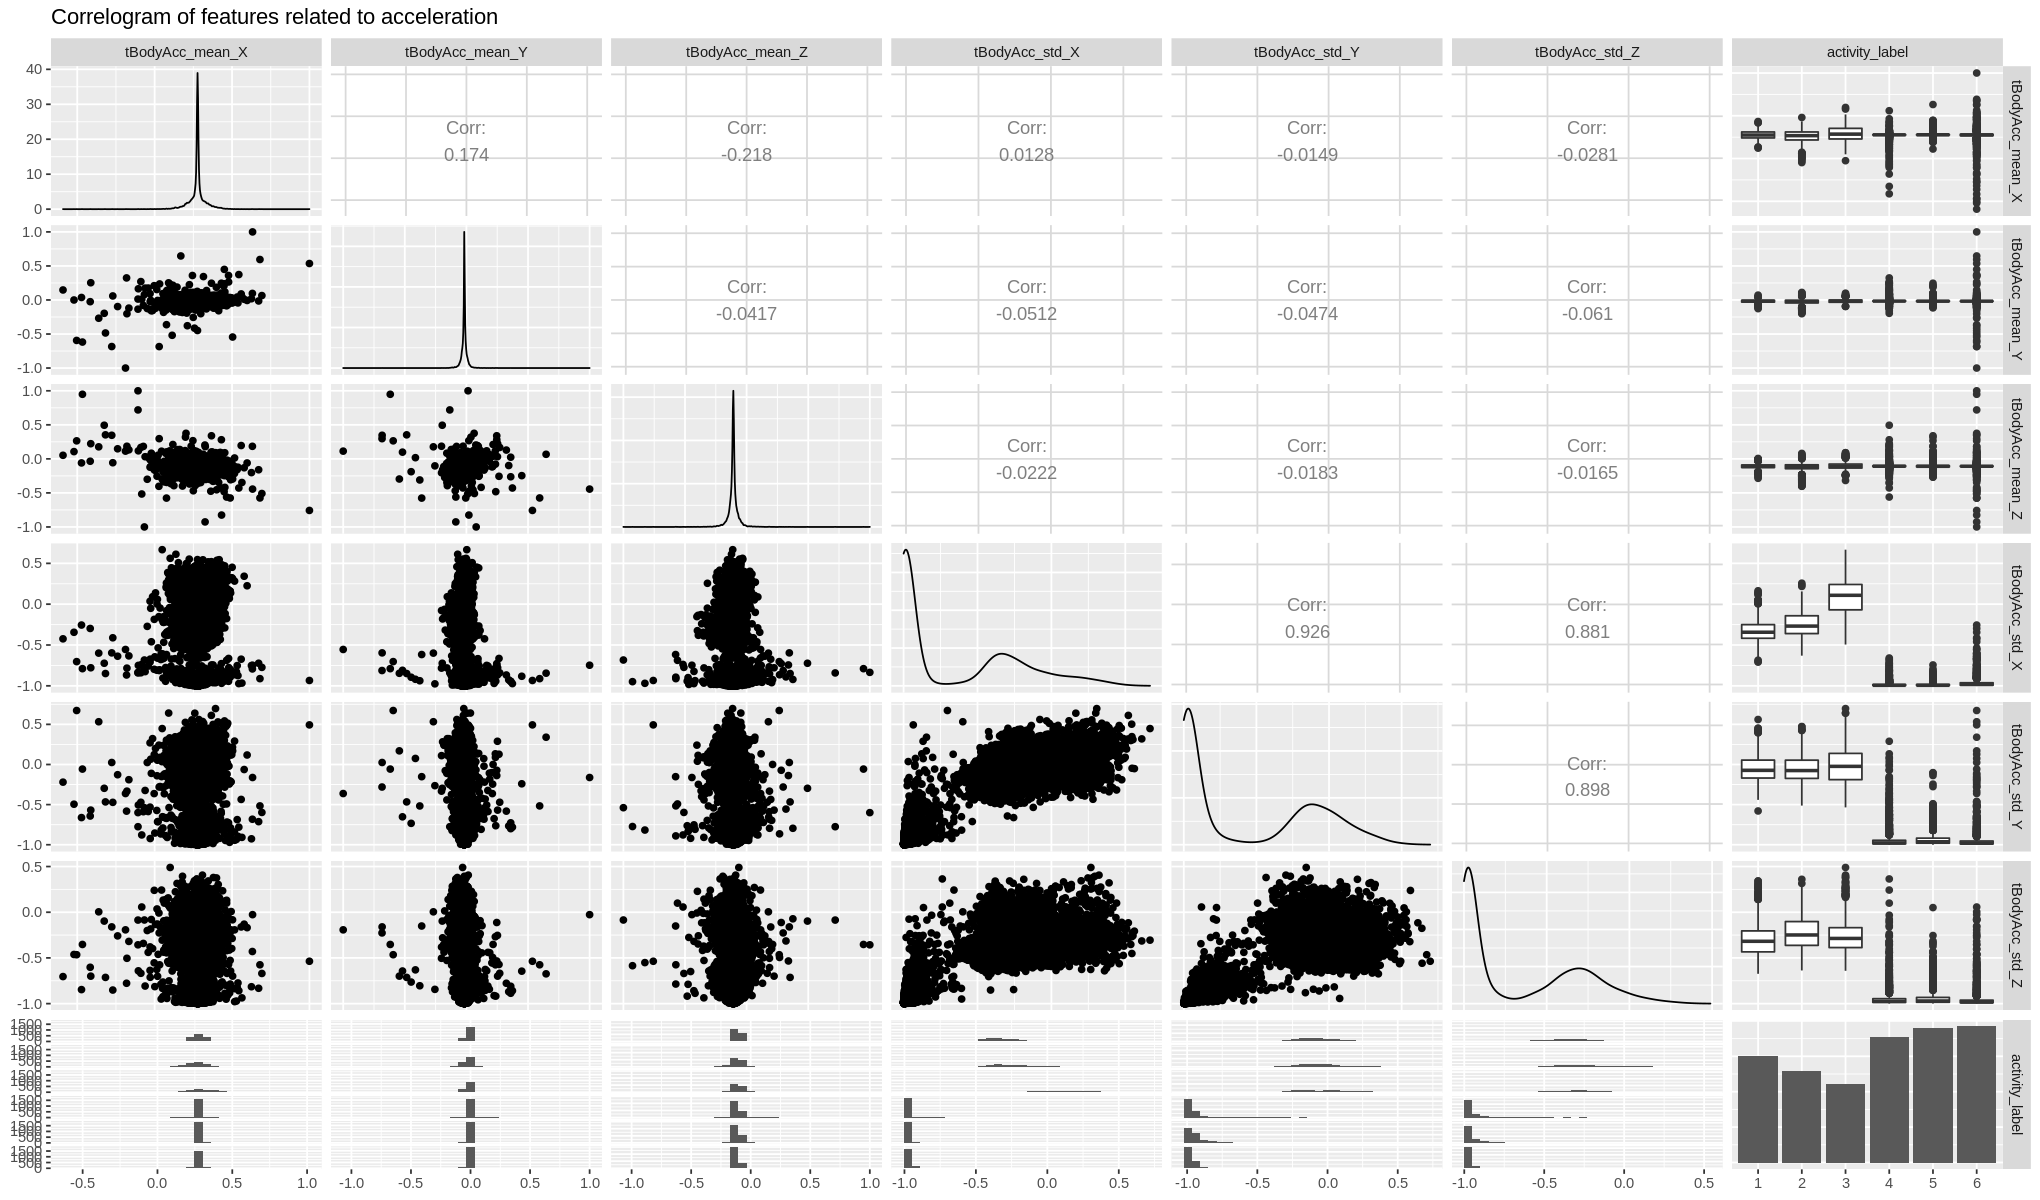

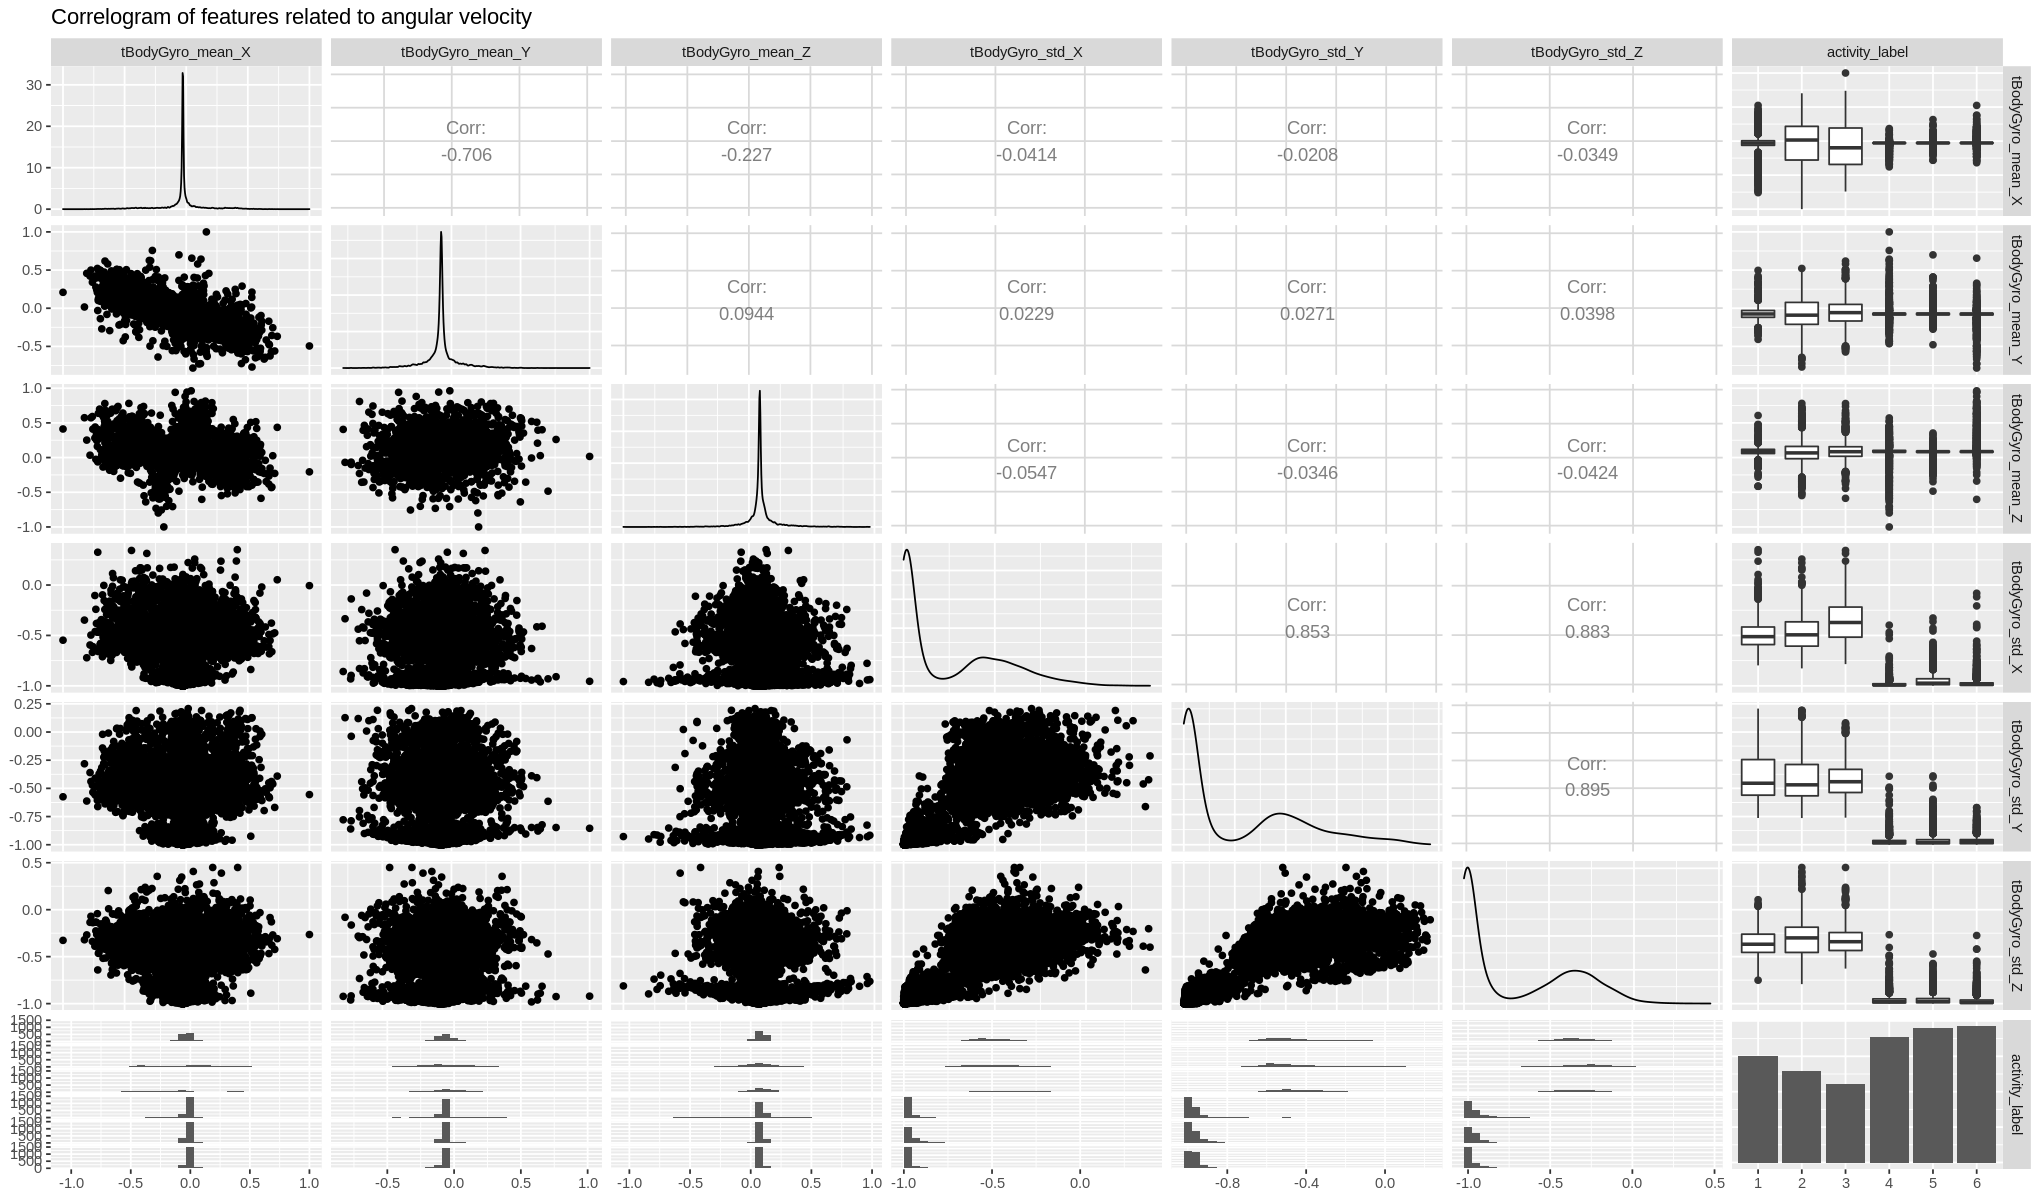

In [47]:
#Correlation graph of features related to acceleration
correlation_acc <- ggpairs(relevant_acc_columns, title ="Correlogram of features related to acceleration")
correlation_acc

#Correlation graph of features related to angular velocity 
correlation_ang <- ggpairs(relevant_ang_columns, title ="Correlogram of features related to angular velocity")
correlation_ang

Since there are too many features available (561), we will select 6 variables that we hypothesize to be relevant. We will focus on a small subset of all the variables instead of looking at all of them. Then we will examine the variables we have picked using visualization and other techniques.

The 12 variables are: 

1. tBodyAcc-mean()-X, 
2. tBodyAcc-mean()-Y,
3. tBodyAcc-mean()-Z, 
4. tBodyGyro-mean()-X, 
5. tBodyGyro-mean()-Y and 
6. tBodyGyro-mean()-Z.

**add the other 6 variables later**

In [49]:
# created a data frame contraining only the 6 variables mentioned above and the activity labels. 
training_subset <- activity_train %>%
    select(tBodyAcc_mean_X:tBodyAcc_std_Z,tBodyGyro_mean_X:tBodyGyro_std_Z, activity_label)
   
tail(training_subset)

#unselected tBodyGyro_std_Y because it contained 75 NA values ~ need to figure out how to deal with the missing values

tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyGyro_mean_X,tBodyGyro_mean_Y,tBodyGyro_mean_Z,tBodyGyro_std_X,tBodyGyro_std_Y,tBodyGyro_std_Z,activity_label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0.1471456,-0.04690785,-0.06933821,-0.3486862,0.01805700,-0.3647159,0.42234149,-0.36894638,-0.30291286,-0.4587513,-0.6009614,-0.2144988,2
0.1922746,-0.03364257,-0.10594911,-0.3548408,-0.09250435,-0.3129097,0.09440037,-0.12238811,0.01183796,-0.3387285,-0.5922064,-0.2908849,2
0.3633846,-0.03921402,-0.10591509,-0.3053880,0.02814774,-0.1963729,0.06210732,-0.04315641,0.11359406,-0.4640369,-0.5181490,-0.1396287,2
0.3499661,0.03007744,-0.11578796,-0.3296381,-0.04214289,-0.2501807,-0.12371500,0.08631957,0.26142304,-0.4219774,-0.5570594,-0.1975039,2
0.2375938,0.01846687,-0.09649893,-0.3231143,-0.22977539,-0.2075736,-0.33591203,0.09934677,0.35505812,-0.6678579,-0.5551660,-0.3426199,2
0.1536272,-0.01843651,-0.13701846,-0.3300460,-0.19525335,-0.1643388,-0.20822948,-0.03865400,0.24610106,-0.6166534,-0.5085570,-0.3138543,2


### III. Tables

**REVISE THIS LATER WITH UPDATED VARIABLES**

After splitting the dataset into a train and test set, we selected six variables for our analysis:

1. tBodyAcc-mean()-X,
2. tBodyAcc-mean()-Y,
3. tBodyAcc-mean()-Z,
4. tBodyGyro-mean()-X,
5. tBodyGyro-mean()-Y and
6. tBodyGyro-mean()-Z.

We made a table including these variables and calculated the number of rows with missing data - zero. Next, we summarized the training data to inspect the possible scaling and centering; it appears to be already scaled by looking at the min and max values, although we should consider scaling when creating a recipe. Lastly, we calculated the number of observations for each activity to ensure equal proportions to minimize the model’s bias towards one activity.

In [50]:
missing_data <- training_subset %>%
    summarize(missing_data = sum(is.na(training_subset)))

# Table 1: how many rows have missing data
kable(missing_data, caption = "Number of rows with missing data")



Table: Number of rows with missing data

| missing_data|
|------------:|
|            0|

**need to consider missing data**

In [51]:
#Table 2: create summary table of training data
summary(training_subset) 

# We can notice that most of the data has been scaled to have same spread. 
#The min (-1.0000) and max (1.0000) values are still not all the same. 
#Though, they are not centered as each variable do not have a mean of 0.

 tBodyAcc_mean_X   tBodyAcc_mean_Y    tBodyAcc_mean_Z   tBodyAcc_std_X   
 Min.   :-0.5920   Min.   :-0.68489   Min.   :-0.8255   Min.   :-1.0000  
 1st Qu.: 0.2654   1st Qu.:-0.02406   1st Qu.:-0.1199   1st Qu.:-0.9932  
 Median : 0.2773   Median :-0.01713   Median :-0.1085   Median :-0.9620  
 Mean   : 0.2752   Mean   :-0.01775   Mean   :-0.1088   Mean   :-0.6502  
 3rd Qu.: 0.2868   3rd Qu.:-0.01093   3rd Qu.:-0.0985   3rd Qu.:-0.2991  
 Max.   : 1.0000   Max.   : 1.00000   Max.   : 1.0000   Max.   : 0.6672  
 tBodyAcc_std_Y    tBodyAcc_std_Z    tBodyGyro_mean_X   tBodyGyro_mean_Y  
 Min.   :-1.0000   Min.   :-1.0000   Min.   :-1.00000   Min.   :-0.77027  
 1st Qu.:-0.9794   1st Qu.:-0.9813   1st Qu.:-0.04256   1st Qu.:-0.09937  
 Median :-0.9016   Median :-0.9109   Median :-0.02776   Median :-0.07471  
 Mean   :-0.5698   Mean   :-0.6651   Mean   :-0.03345   Mean   :-0.07335  
 3rd Qu.:-0.1168   3rd Qu.:-0.3256   3rd Qu.:-0.01548   3rd Qu.:-0.05393  
 Max.   : 0.6725   Max.   : 0.48

In [52]:
# data frame that has been grouped by each activity data
each_activity_data <- training_subset %>%
    group_by(activity_label)

# Number of observations for each activity
count_activity_data <- summarize(each_activity_data, count = n()) 

# Table 3: how many observations for each activity
kable(count_activity_data, caption = "Number of observations for each activity")

`summarise()` ungrouping output (override with `.groups` argument)





Table: Number of observations for each activity

|activity_label | count|
|:--------------|-----:|
|1              |  1133|
|2              |   970|
|3              |   837|
|4              |  1329|
|5              |  1429|
|6              |  1443|

### IV. Plots

Certain activity types are more concentrated in one area of the scatter plot (body acceleration (m/s^2) vs. angular velocity(rads/s)) suggesting a moderate correlation between the estimated acceleration and angular velocity. Therefore, we expect to see a distinct acceleration and angular velocity for each activity type. This preliminary analysis confirms the validity of using both body acceleration and angular velocity in the (x,y,z) directions as the main predictors.

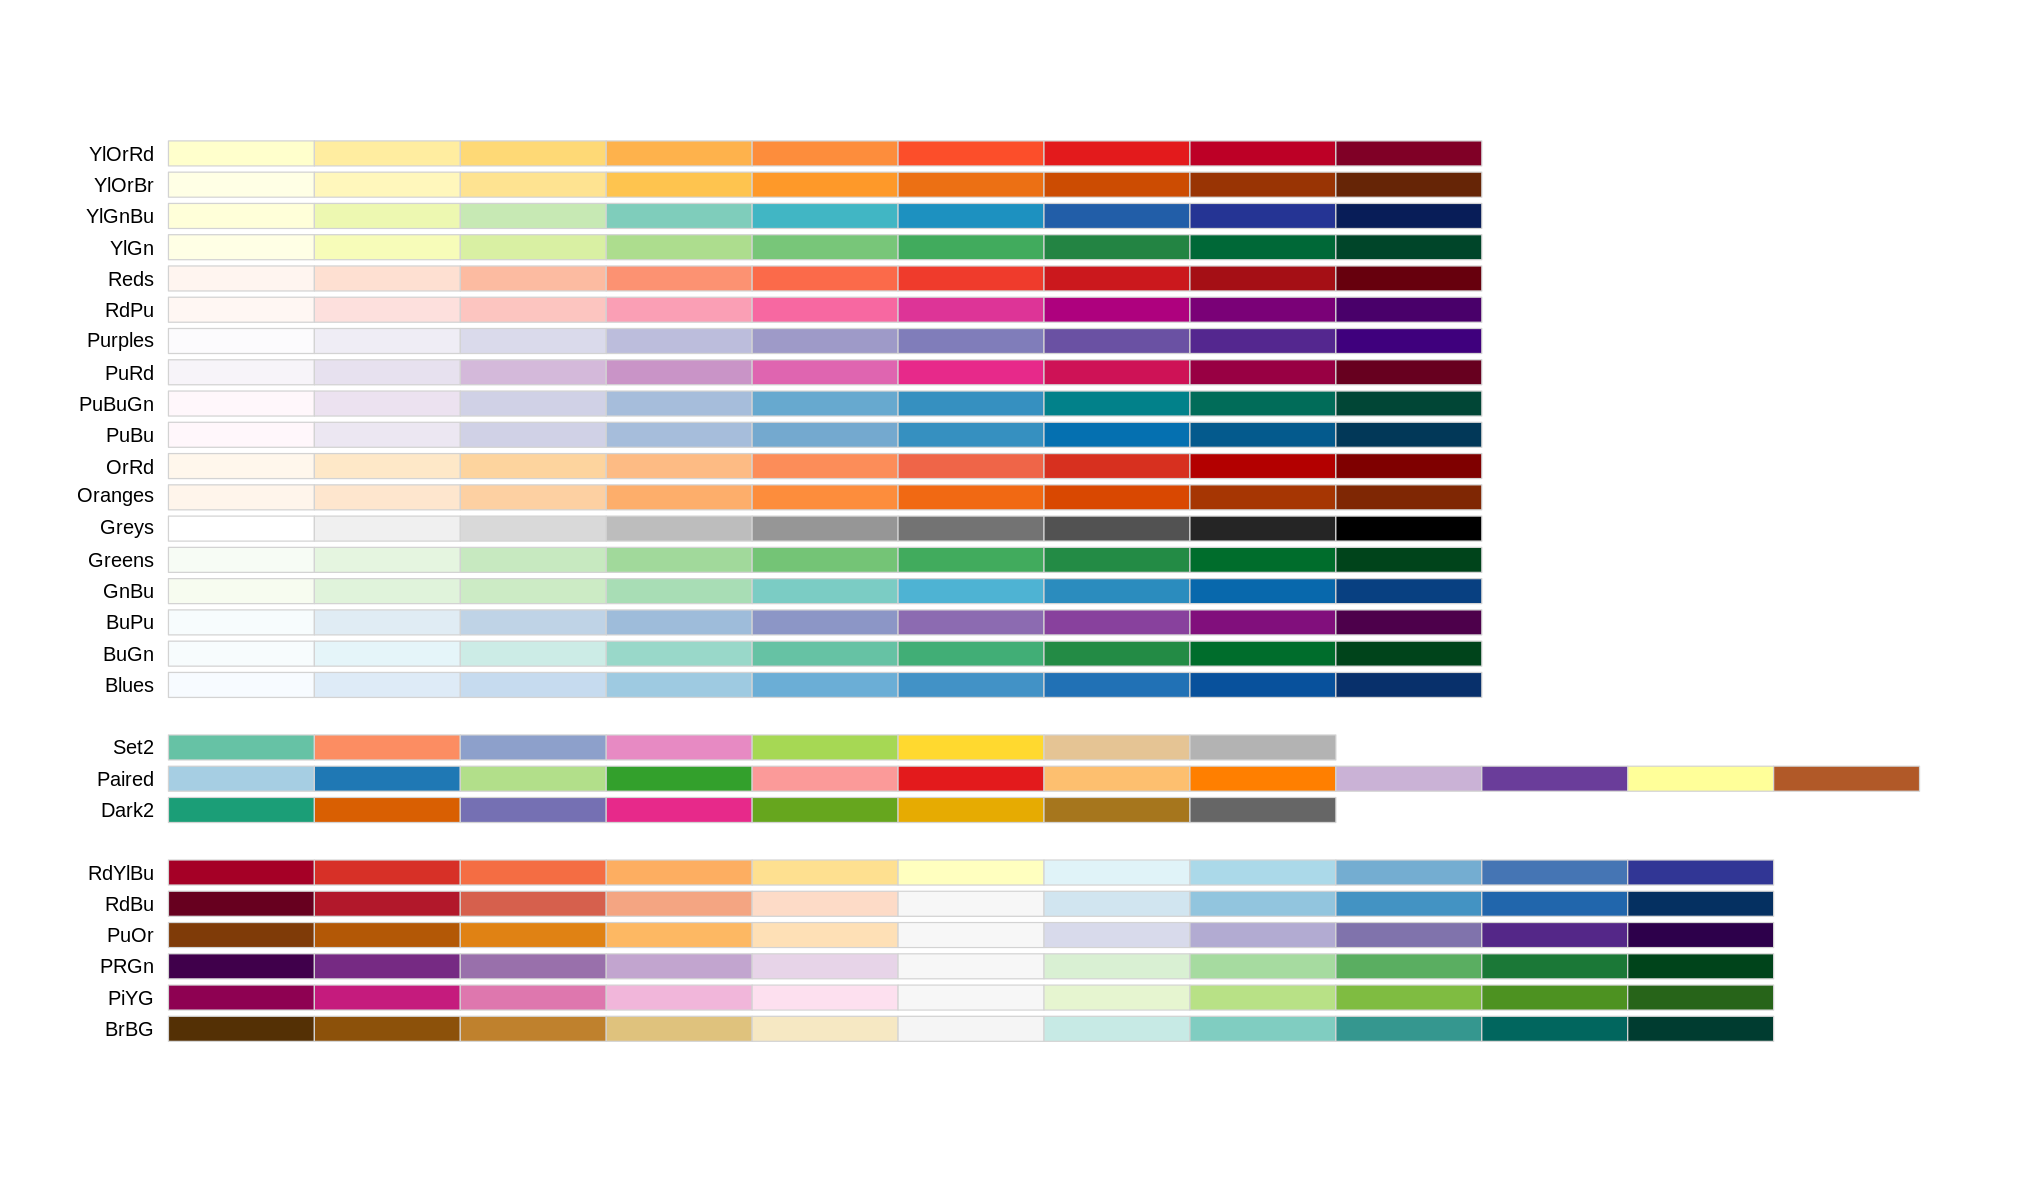

In [53]:
options(repr.plot.width=17, repr.plot.height=10)

# checking colour options to ensure colour blind friendliness of the plots
display.brewer.all(colorblindFriendly = TRUE)

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



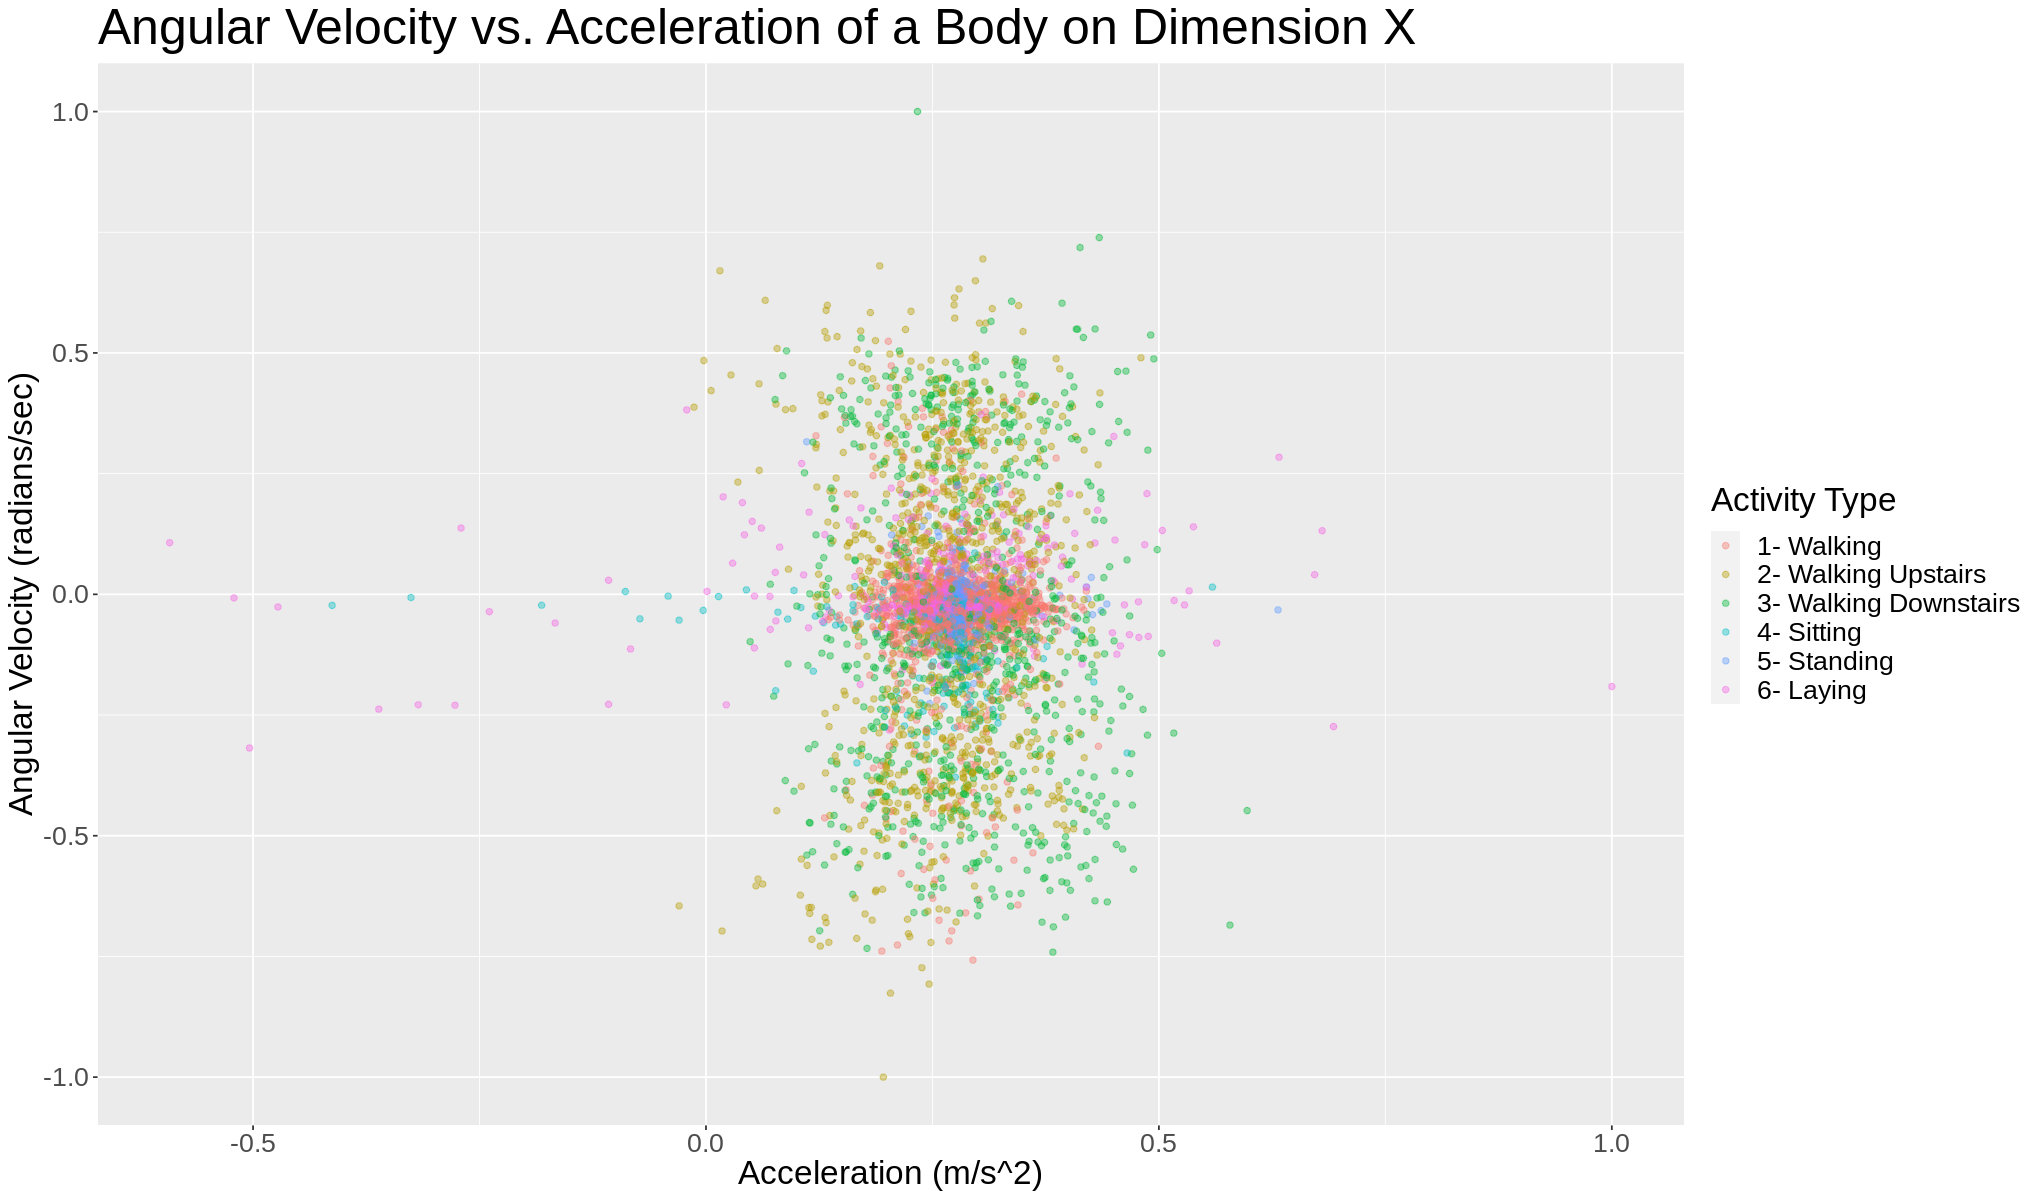

In [54]:
#  Using only training data, compares the distributions of each of the predictor variables 

#Plot 1: Angular Velocity vs. Acceleration of a Body on Dimension X
accl_gyro_x <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_X, y = tBodyGyro_mean_X, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension X") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 20), plot.title = element_text(size=30))

accl_gyro_x

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



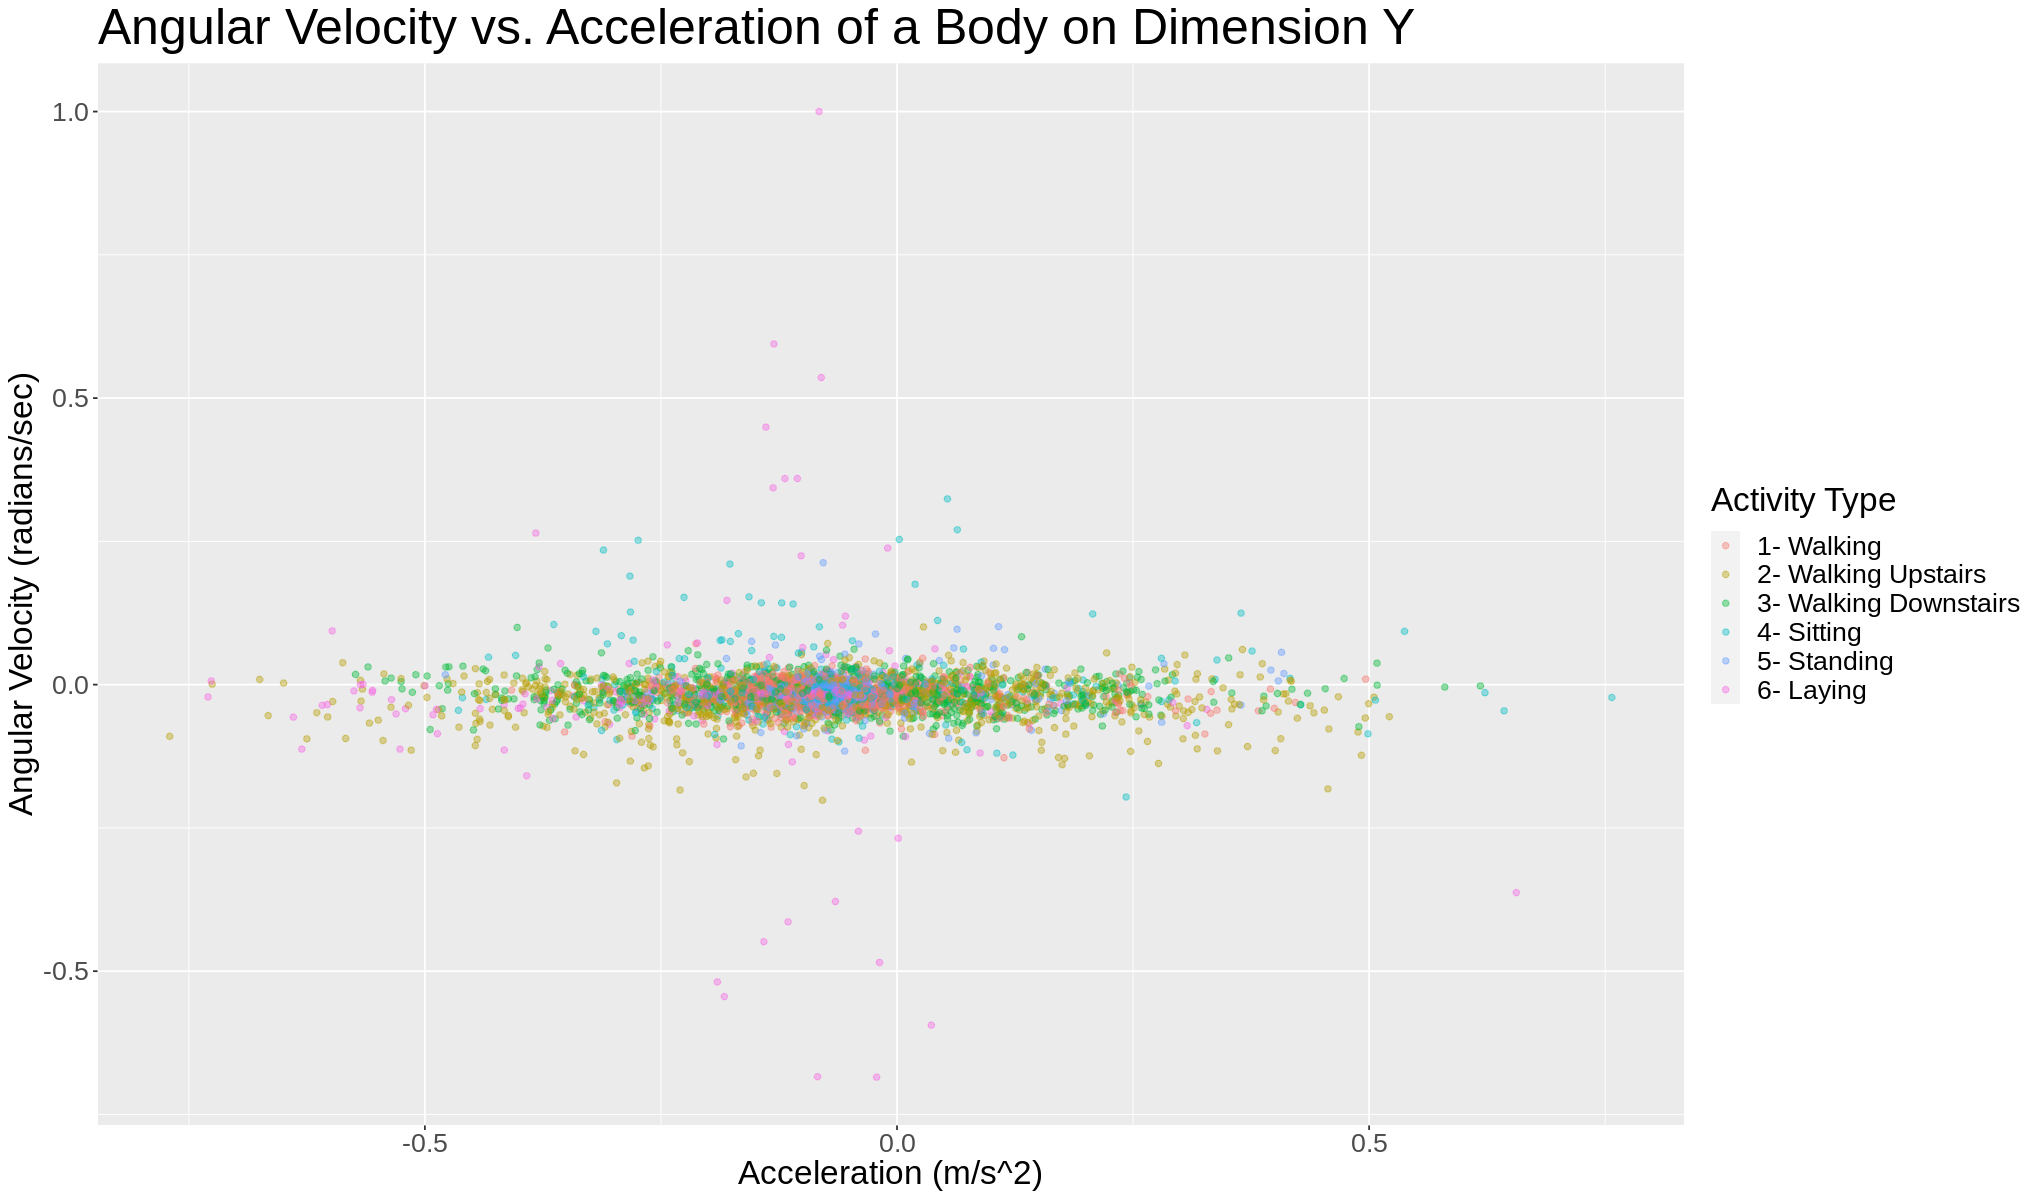

In [55]:
# Plot 2: Angular Velocity vs. Acceleration of a Body on Dimension Y
accl_gyro_y <- training_subset %>%
  ggplot(aes(x = tBodyGyro_mean_Y, y = tBodyAcc_mean_Y, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension Y") +
  geom_point(alpha = 0.4) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 20), plot.title = element_text(size=30))

accl_gyro_y

Scale for 'colour' is already present. Adding another scale for 'colour',
which will replace the existing scale.



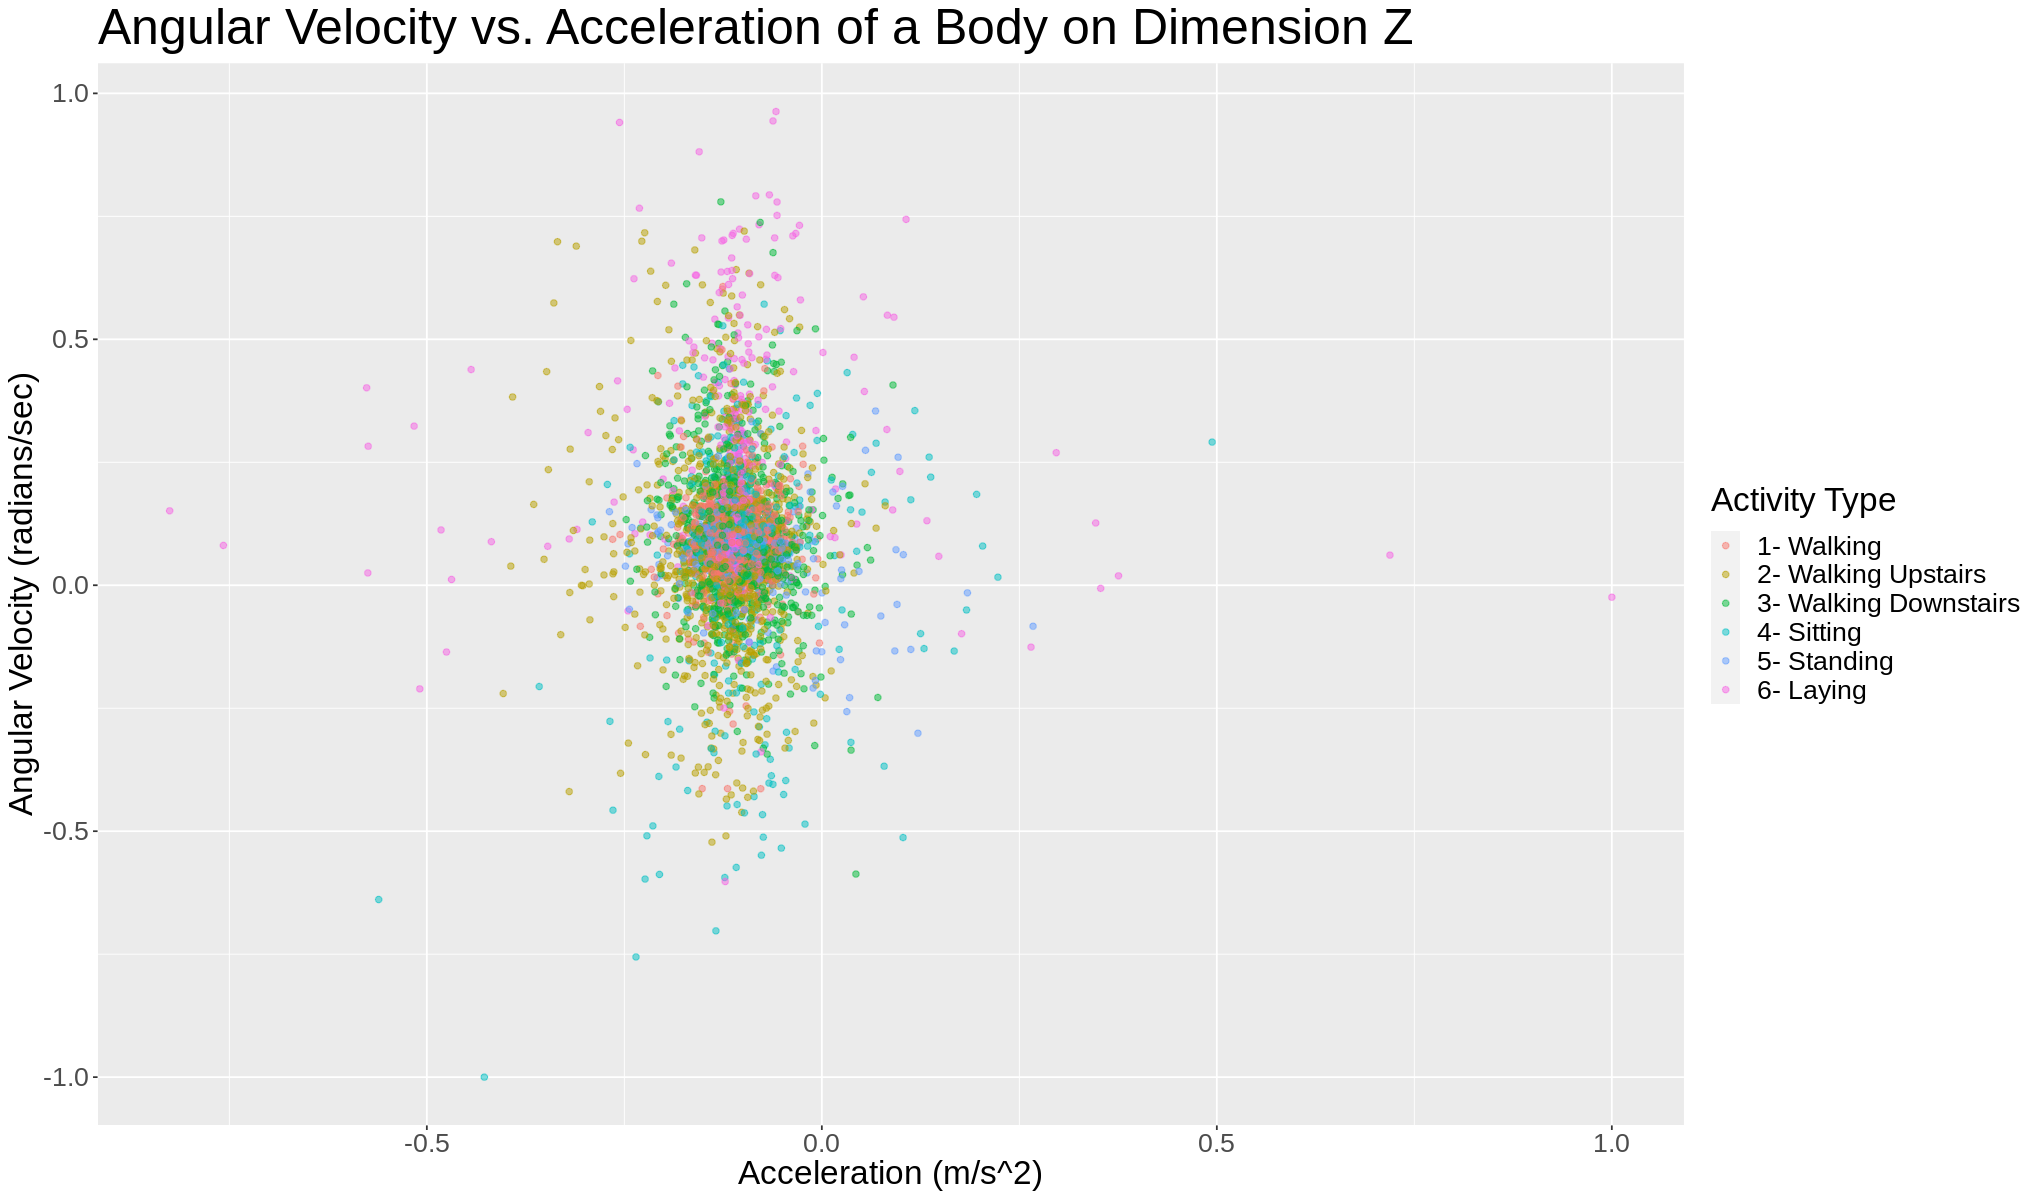

In [56]:
# Plot 3: Angular Velocity vs. Acceleration of a Body on Dimension Z
accl_gyro_z <- training_subset %>%
  ggplot(aes(x = tBodyAcc_mean_Z, y = tBodyGyro_mean_Z, color = activity_label)) +
  ggtitle("Angular Velocity vs. Acceleration of a Body on Dimension Z") +
  geom_point(alpha = 0.5) +
  labs(x = "Acceleration (m/s^2)", y = "Angular Velocity (radians/sec)", color = "Activity Type") +
  scale_color_brewer(palette = "Set2") +
  scale_color_discrete(labels = c("1- Walking", "2- Walking Upstairs", "3- Walking Downstairs", "4- Sitting", "5- Standing", "6- Laying")) +
  theme(text = element_text(size = 20), plot.title = element_text(size=30))

accl_gyro_z

### V. Perform Data Analysis

In [57]:
# Activity Labels 
#1 WALKING
#2 WALKING_UPSTAIRS
#3 WALKING_DOWNSTAIRS
#4 SITTING
#5 STANDING
#6 LAYING

#Create KNN model using K = 3
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 3) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")
knn_spec

#Create recipe (scaling needed with new predictors)
recipe <- recipe(activity_label ~. , data = training_subset) %>% 
  step_center(all_predictors()) %>% 
  step_scale(all_predictors())  
recipe

#Create workflow 
knn_fit <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec) %>% 
  fit(data = training_subset)
knn_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 3
  weight_func = rectangular

Computational engine: kknn 


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         12

Operations:

Centering for all_predictors()
Scaling for all_predictors()

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_center()
● step_scale()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~3, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2330206
Best kernel: rectangular
Best k: 3

In [59]:
#Prediction 
activity_predictions <- predict(knn_fit, activity_test) %>%
      bind_cols(activity_test)
activity_predictions

.pred_class,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,"tBodyAcc_arCoeff_X,1","tBodyAcc_arCoeff_X,2","tBodyAcc_arCoeff_X,3","tBodyAcc_arCoeff_X,4","tBodyAcc_arCoeff_Y,1","tBodyAcc_arCoeff_Y,2","tBodyAcc_arCoeff_Y,3","tBodyAcc_arCoeff_Y,4","tBodyAcc_arCoeff_Z,1","tBodyAcc_arCoeff_Z,2","tBodyAcc_arCoeff_Z,3","tBodyAcc_arCoeff_Z,4","tBodyAcc_correlation_X,Y","tBodyAcc_correlation_X,Z","tBodyAcc_correlation_Y,Z",tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,"tGravityAcc_arCoeff_X,1","tGravityAcc_arCoeff_X,2","tGravityAcc_arCoeff_X,3","tGravityAcc_arCoeff_X,4","tGravityAcc_arCoeff_Y,1","tGravityAcc_arCoeff_Y,2","tGravityAcc_arCoeff_Y,3","tGravityAcc_arCoeff_Y,4","tGravityAcc_arCoeff_Z,1",⋯,"fBodyGyro_bandsEnergy_25,48_1","fBodyGyro_bandsEnergy_1,8_2","fBodyGyro_bandsEnergy_9,16_2","fBodyGyro_bandsEnergy_17,24_2","fBodyGyro_bandsEnergy_25,32_2","fBodyGyro_bandsEnergy_33,40_2","fBodyGyro_bandsEnergy_41,48_2","fBodyGyro_bandsEnergy_49,56_2","fBodyGyro_bandsEnergy_57,64_2","fBodyGyro_bandsEnergy_1,16_2","fBodyGyro_bandsEnergy_17,32_2","fBodyGyro_bandsEnergy_33,48_2","fBodyGyro_bandsEnergy_49,64_2","fBodyGyro_bandsEnergy_1,24_2","fBodyGyro_bandsEnergy_25,48_2",fBodyAccMag_mean,fBodyAccMag_std,fBodyAccMag_mad,fBodyAccMag_max,fBodyAccMag_min,fBodyAccMag_sma,fBodyAccMag_energy,fBodyAccMag_iqr,fBodyAccMag_entropy,fBodyAccMag_maxInds,fBodyAccMag_meanFreq,fBodyAccMag_skewness,fBodyAccMag_kurtosis,fBodyBodyAccJerkMag_mean,fBodyBodyAccJerkMag_std,fBodyBodyAccJerkMag_mad,fBodyBodyAccJerkMag_max,fBodyBodyAccJerkMag_min,fBodyBodyAccJerkMag_sma,fBodyBodyAccJerkMag_energy,fBodyBodyAccJerkMag_iqr,fBodyBodyAccJerkMag_entropy,fBodyBodyAccJerkMag_maxInds,fBodyBodyAccJerkMag_meanFreq,fBodyBodyAccJerkMag_skewness,fBodyBodyAccJerkMag_kurtosis,fBodyBodyGyroMag_mean,fBodyBodyGyroMag_std,fBodyBodyGyroMag_mad,fBodyBodyGyroMag_max,fBodyBodyGyroMag_min,fBodyBodyGyroMag_sma,fBodyBodyGyroMag_energy,fBodyBodyGyroMag_iqr,fBodyBodyGyroMag_entropy,fBodyBodyGyroMag_maxInds,fBodyBodyGyroMag_meanFreq,fBodyBodyGyroMag_skewness,fBodyBodyGyroMag_kurtosis,fBodyBodyGyroJerkMag_mean,fBodyBodyGyroJerkMag_std,fBodyBodyGyroJerkMag_mad,fBodyBodyGyroJerkMag_max,fBodyBodyGyroJerkMag_min,fBodyBodyGyroJerkMag_sma,fBodyBodyGyroJerkMag_energy,fBodyBodyGyroJerkMag_iqr,fBodyBodyGyroJerkMag_entropy,fBodyBodyGyroJerkMag_maxInds,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>

In [60]:
#Classifier's Accuracy 
activity_prediction_accuracy <- activity_predictions %>%
        metrics(truth = activity_label, estimate = .pred_class)  
activity_prediction_accuracy


#Confusion matrix
activity_mat <- activity_predictions %>% 
      conf_mat(truth = activity_label, estimate = .pred_class)
activity_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7660917
kap,multiclass,0.7169095


          Truth
Prediction   1   2   3   4   5   6
         1 347  73  28   1   0   1
         2  27 219  43   1   0   0
         3   3  31 207   0   0   0
         4   0   0   0 305  87  63
         5   0   0   0  88 363  36
         6   0   0   0  48  26 380

In [61]:
#10-fold cross-validation 
activity_vfold <- vfold_cv(training_subset, v = 10, strata = activity_label)

#Perform workflow analysis again 
activity_resample_fit <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_spec) %>%
      fit_resamples(resamples = activity_vfold)

#Accuracy of classifier's validation across the folds
activity_metrics <- activity_resample_fit %>% 
    collect_metrics()
activity_metrics

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.7700570,10,0.006024363
roc_auc,hand_till,0.9296877,10,0.001875478


In [62]:
#Create new K-nearest neighbours model specification to tune K value 
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
knn_tune

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


In [63]:
#Create new workflow with recipe and new knn_tune specification 
knn_results <- workflow() %>%
      add_recipe(recipe) %>%
      add_model(knn_tune) %>%
      tune_grid(resamples = activity_vfold, grid = 10) %>%
      collect_metrics()
knn_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,multiclass,0.7511532,10,0.004611980,Model1
2,roc_auc,hand_till,0.9070284,10,0.002971402,Model1
3,accuracy,multiclass,0.7700570,10,0.006024363,Model2
⋮,⋮,⋮,⋮,⋮,⋮,⋮
12,roc_auc,hand_till,0.9585464,10,0.001204981,Model8
14,accuracy,multiclass,0.7641785,10,0.003961421,Model9
14,roc_auc,hand_till,0.9595086,10,0.001167988,Model9


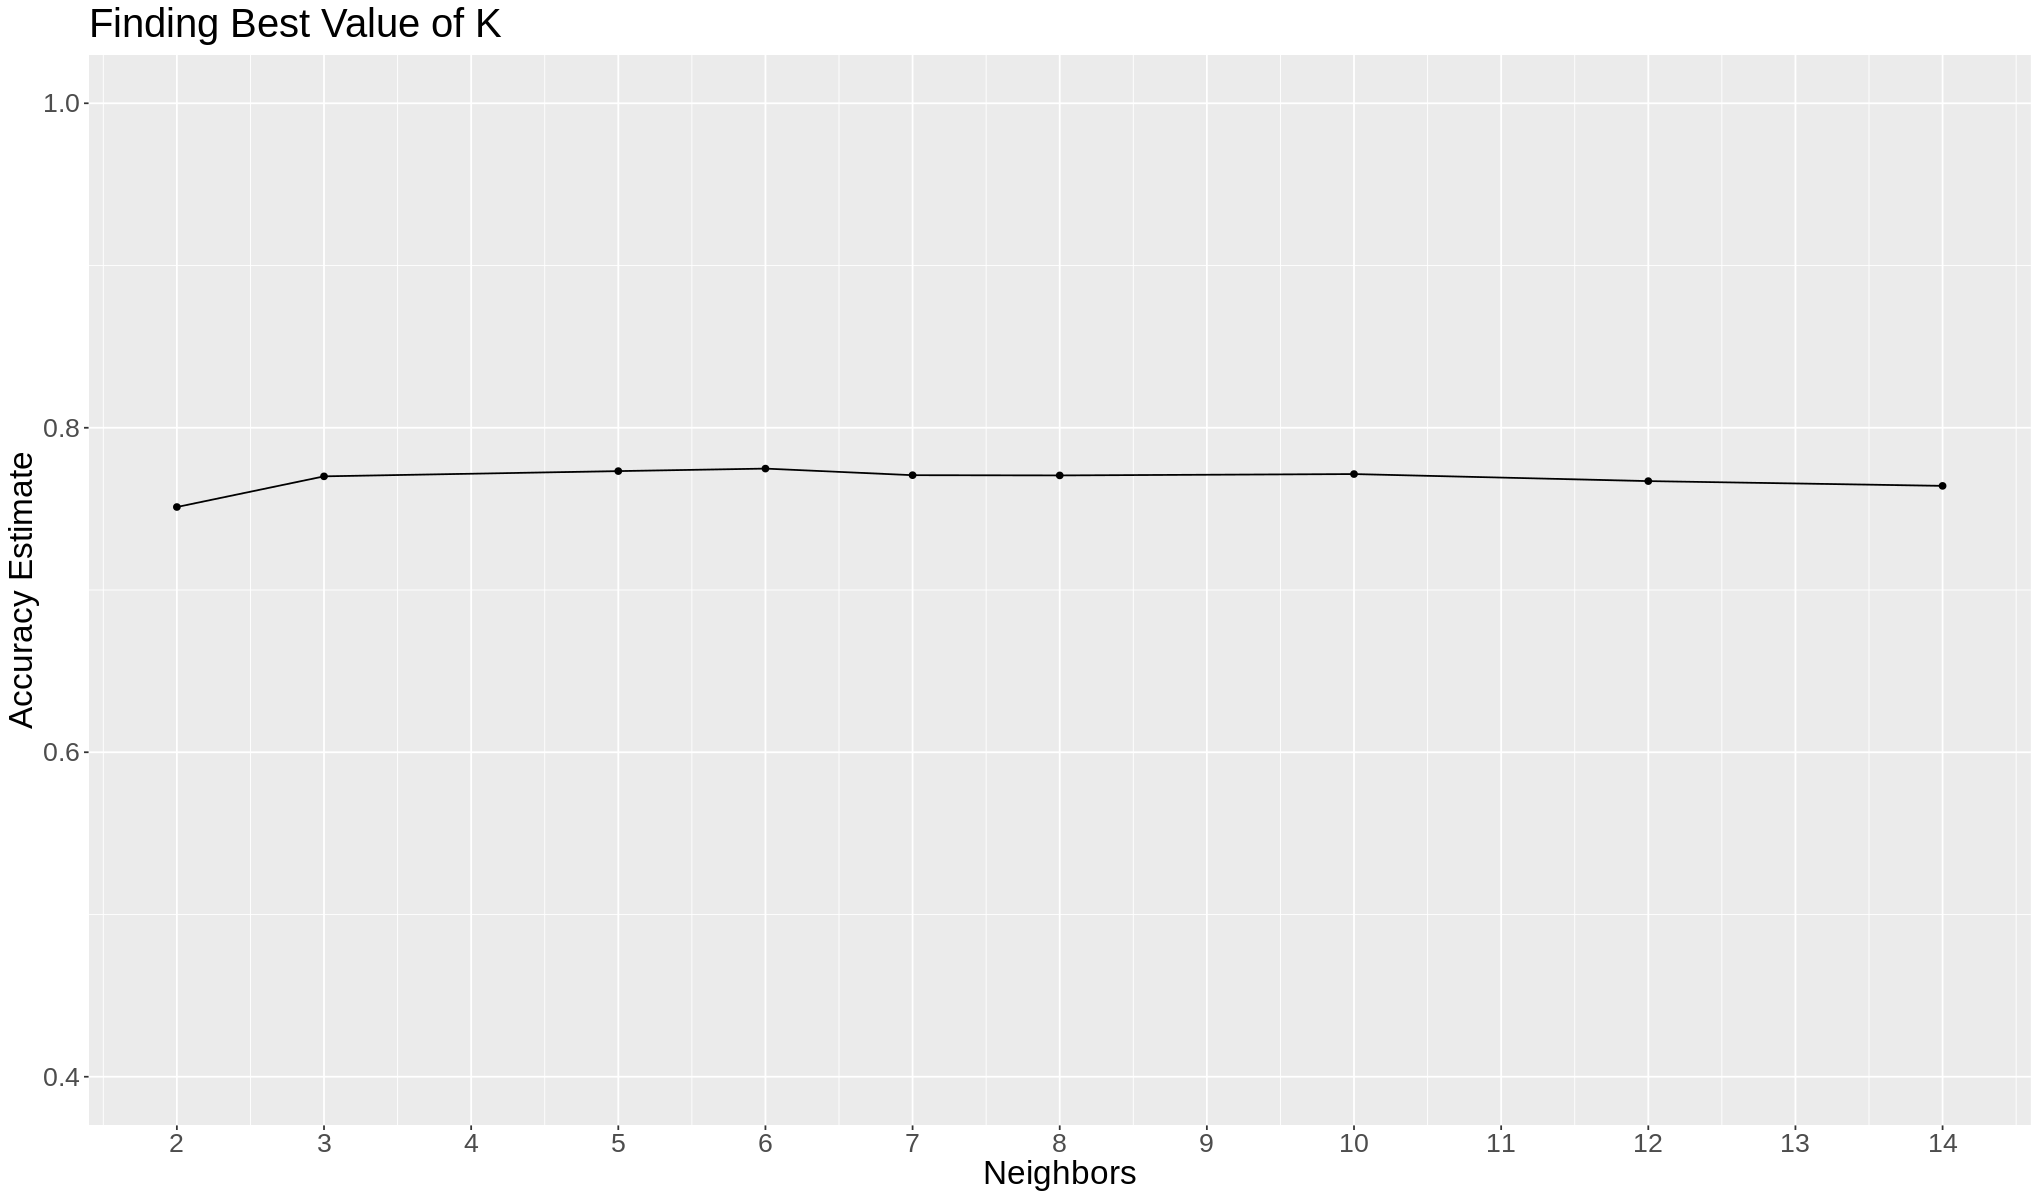

In [64]:
#Find best value of number of neighbours 
accuracies <- knn_results %>% 
      filter(.metric == "accuracy")

#Plot mean vs neighbours using accuracies dataset 
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 15, by = 1)) +  # adjusting the x-axis
      scale_y_continuous(limits = c(0.4, 1.0)) + # adjusting the y-axis 
      theme(text = element_text(size = 20)) +
      ggtitle("Finding Best Value of K")
accuracy_versus_k

In [42]:
#Create new KNN model using K = 6
knn_spec_new <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>% 
  set_engine("kknn") %>% 
  set_mode("classification")

#Create workflow 
knn_fit <- workflow() %>% 
  add_recipe(recipe) %>% 
  add_model(knn_spec_new) %>% 
  fit(data = training_subset)

#Prediction 
activity_predictions <- predict(knn_fit, activity_test) %>%
      bind_cols(activity_test)
activity_predictions

#Classifier's Accuracy 
activity_prediction_accuracy <- activity_predictions %>%
        metrics(truth = activity_label, estimate = .pred_class)  
activity_prediction_accuracy
#result ~ 77 % improved signficantly compared to using only 6 predictors 

#Confusion matrix
activity_mat <- activity_predictions %>% 
      conf_mat(truth = activity_label, estimate = .pred_class)
activity_mat

.pred_class,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,tBodyAcc_max_Y,tBodyAcc_max_Z,tBodyAcc_min_X,tBodyAcc_min_Y,tBodyAcc_min_Z,tBodyAcc_sma,tBodyAcc_energy_X,tBodyAcc_energy_Y,tBodyAcc_energy_Z,tBodyAcc_iqr_X,tBodyAcc_iqr_Y,tBodyAcc_iqr_Z,tBodyAcc_entropy_X,tBodyAcc_entropy_Y,tBodyAcc_entropy_Z,"tBodyAcc_arCoeff_X,1","tBodyAcc_arCoeff_X,2","tBodyAcc_arCoeff_X,3","tBodyAcc_arCoeff_X,4","tBodyAcc_arCoeff_Y,1","tBodyAcc_arCoeff_Y,2","tBodyAcc_arCoeff_Y,3","tBodyAcc_arCoeff_Y,4","tBodyAcc_arCoeff_Z,1","tBodyAcc_arCoeff_Z,2","tBodyAcc_arCoeff_Z,3","tBodyAcc_arCoeff_Z,4","tBodyAcc_correlation_X,Y","tBodyAcc_correlation_X,Z","tBodyAcc_correlation_Y,Z",tGravityAcc_mean_X,tGravityAcc_mean_Y,tGravityAcc_mean_Z,tGravityAcc_std_X,tGravityAcc_std_Y,tGravityAcc_std_Z,tGravityAcc_mad_X,tGravityAcc_mad_Y,tGravityAcc_mad_Z,tGravityAcc_max_X,tGravityAcc_max_Y,tGravityAcc_max_Z,tGravityAcc_min_X,tGravityAcc_min_Y,tGravityAcc_min_Z,tGravityAcc_sma,tGravityAcc_energy_X,tGravityAcc_energy_Y,tGravityAcc_energy_Z,tGravityAcc_iqr_X,tGravityAcc_iqr_Y,tGravityAcc_iqr_Z,tGravityAcc_entropy_X,tGravityAcc_entropy_Y,tGravityAcc_entropy_Z,"tGravityAcc_arCoeff_X,1","tGravityAcc_arCoeff_X,2","tGravityAcc_arCoeff_X,3","tGravityAcc_arCoeff_X,4","tGravityAcc_arCoeff_Y,1","tGravityAcc_arCoeff_Y,2","tGravityAcc_arCoeff_Y,3","tGravityAcc_arCoeff_Y,4","tGravityAcc_arCoeff_Z,1",⋯,"fBodyGyro_bandsEnergy_25,48_1","fBodyGyro_bandsEnergy_1,8_2","fBodyGyro_bandsEnergy_9,16_2","fBodyGyro_bandsEnergy_17,24_2","fBodyGyro_bandsEnergy_25,32_2","fBodyGyro_bandsEnergy_33,40_2","fBodyGyro_bandsEnergy_41,48_2","fBodyGyro_bandsEnergy_49,56_2","fBodyGyro_bandsEnergy_57,64_2","fBodyGyro_bandsEnergy_1,16_2","fBodyGyro_bandsEnergy_17,32_2","fBodyGyro_bandsEnergy_33,48_2","fBodyGyro_bandsEnergy_49,64_2","fBodyGyro_bandsEnergy_1,24_2","fBodyGyro_bandsEnergy_25,48_2",fBodyAccMag_mean,fBodyAccMag_std,fBodyAccMag_mad,fBodyAccMag_max,fBodyAccMag_min,fBodyAccMag_sma,fBodyAccMag_energy,fBodyAccMag_iqr,fBodyAccMag_entropy,fBodyAccMag_maxInds,fBodyAccMag_meanFreq,fBodyAccMag_skewness,fBodyAccMag_kurtosis,fBodyBodyAccJerkMag_mean,fBodyBodyAccJerkMag_std,fBodyBodyAccJerkMag_mad,fBodyBodyAccJerkMag_max,fBodyBodyAccJerkMag_min,fBodyBodyAccJerkMag_sma,fBodyBodyAccJerkMag_energy,fBodyBodyAccJerkMag_iqr,fBodyBodyAccJerkMag_entropy,fBodyBodyAccJerkMag_maxInds,fBodyBodyAccJerkMag_meanFreq,fBodyBodyAccJerkMag_skewness,fBodyBodyAccJerkMag_kurtosis,fBodyBodyGyroMag_mean,fBodyBodyGyroMag_std,fBodyBodyGyroMag_mad,fBodyBodyGyroMag_max,fBodyBodyGyroMag_min,fBodyBodyGyroMag_sma,fBodyBodyGyroMag_energy,fBodyBodyGyroMag_iqr,fBodyBodyGyroMag_entropy,fBodyBodyGyroMag_maxInds,fBodyBodyGyroMag_meanFreq,fBodyBodyGyroMag_skewness,fBodyBodyGyroMag_kurtosis,fBodyBodyGyroJerkMag_mean,fBodyBodyGyroJerkMag_std,fBodyBodyGyroJerkMag_mad,fBodyBodyGyroJerkMag_max,fBodyBodyGyroJerkMag_min,fBodyBodyGyroJerkMag_sma,fBodyBodyGyroJerkMag_energy,fBodyBodyGyroJerkMag_iqr,fBodyBodyGyroJerkMag_entropy,fBodyBodyGyroJerkMag_maxInds,fBodyBodyGyroJerkMag_meanFreq,fBodyBodyGyroJerkMag_skewness,fBodyBodyGyroJerkMag_kurtosis,"angletBodyAccMean,gravity","angletBodyAccJerkMean,gravityMean","angletBodyGyroMean,gravityMean","angletBodyGyroJerkMean,gravityMean","angleX,gravityMean","angleY,gravityMean","angleZ,gravityMean",activity_label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.7726389
kap,multiclass,0.7262153


          Truth
Prediction   1   2   3   4   5   6
         1 398 100  39   0   0   0
         2  27 255  36   0   0   1
         3   5  31 276   0   0   0
         4   0   0   0 309  78  61
         5   0   0   0  91 368  42
         6   0   0   0  44  30 382

### Expected Outcomes and Significance

Overall, our project is going to find a corresponding body acceleration and angular velocity for each activity, with the expectation of a harder classification process for static activities and easier classification process for the dynamic motions. Such a finding could make full use of smartphone sensors to have a wider application and also make this technology more mature. Some factors including the smartphone position around the body and the age of the subject may also affect the experiment results; these factors should be considered and the patterns of more dynamic motions such as dancing and running could be studied in the future research.

### Works Cited


Ahmed, Nadeem, Jahir I. Rafiq, and Md R. Islam. "Enhanced Human Activity Recognition Based on Smartphone Sensor Data using Hybrid Feature Selection Model." Sensors, vol. 20, no. 1, 2020, pp. 317.

Anguita, Davide, et al. A Public Domain Dataset for Human Activity Recognition using Smartphones, 2013.

Foerster, Friedrich, Manfred Smeja, and Jochen Fahrenberg. "Detection of Posture and Motion by Accelerometry: A Validation Study in Ambulatory Monitoring." Computers in Human Behavior, vol. 15, no. 5, 1999, pp. 571-583.